# Clustering bible books

 - Grouping bible books using clustering algorithms
 

In [1]:
import os
import re
import string
import traceback
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from nltk import FreqDist, ngrams
from prettytable import PrettyTable
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

# Prepare data

In [51]:
cwd = os.getcwd() + '/'
min_languages = ['mandeali', 'haryanvi', 'dogri', 'pahari_mahasui', 'baghlayani', 'chambeali', 'kulvi_outer_seraji', 'gaddi', 'bhadrawahi', 'bilaspuri', 'kulvi', 'kangri']
gl_languages = ['english','punjabi', 'malayalam', 'telegu', 'kannada', 'odiya', 'bengali', 'marathi', 'tamil', 'gujarati', 'hindi', 'assamese', 'urdu']
if 'data' not in os.listdir(cwd):
    os.mkdir('data')  
data_path = cwd + 'data/'
if 'metric' not in os.listdir(cwd):
    os.mkdir('metric') 
minority_path = data_path+'minority_languages/'
metric_path = cwd + 'metric/'
gl_path = data_path+'gl/'
sw_path = cwd + 'stop_words/'

In [70]:
for lang in min_languages:
    if lang not in os.listdir(minority_path):
        os.mkdir(minority_path + lang) 

lang_path = '/home/anjaly/Documents/Parallel_corpora/bible_minority/' 
for lang in os.listdir(lang_path):
    book_path = lang_path + lang + '/'
    lang_name = lang.split('_')[0].lower().strip()
    lang_name = re.sub(' ', '_', lang_name)
    for book in os.listdir(book_path):
        df = pd.read_csv(book_path+book)
        fp = open(minority_path + lang_name+'/'+ book.split('.')[0] + '.txt', 'w')
        fp.write('\n'.join(df[df.columns[-1]]))
        fp.close() 

# Supporting modules

In [153]:
def calculate_metric(lang_clusters, book_names):
    
    '''for coloring cells'''
     
    n=4
    temp = len(lang_clusters)/n
    color_codes = ['#BFBFFF', '#A3A3FF', '#7879FF', '#4949FF']
    color_groups = {}
    val = 0
    for i in range(n):
        val1 = val
        val+=temp
        color_groups[str(val1) + '-' + str(val)] = color_codes[i]
    print("color_groups : \n", color_groups)      
    
    '''Preparing data'''
    
    x_metric = book_names
    y_metric = book_names
    rows = []
    colors = []
    for x_book in x_metric:
#         print('---------------------x : ', x_book)
        row = []
        colors_row = []
        row.append(x_book)
        colors_row.append("w")
        for y_book in y_metric:
#             print('y : ', y_book)
            count = 0
            if not y_book == x_book:
                for key, value in lang_clusters.items():
                    for cluster, elements in value.items():        
                        if(set([x_book, y_book]).issubset(set(elements))):
                            count += 1               
                for key, value in color_groups.items():
                    start = int(float(key.split('-')[0]))
                    end = int(float(key.split('-')[1]))
                    if count in range(start, end+1):
                        colors_row.append(value)
                        break    
            else:
                colors_row.append("w")
            row.append(str(count))
        rows.append(row)
        colors.append(colors_row)
    
    '''plotting'''
    
    columns = [""] +y_metric
#     rows = x_metric
    cell_text = rows
    fig, ax = plt.subplots()
    ax.axis('tight')
    ax.axis('off')
    the_table = ax.table(cellText=cell_text,cellColours=colors,
                                   colLabels=columns,loc='center')
    the_table.scale(2, 2)
    plt.show()

In [128]:
def calculate_metric_words(book_names, book_words):      
    
    '''Preparing data'''
    
    x_metric = book_names
    y_metric = book_names
    rows = []
    max_count = 0
    for x_book in x_metric:
#         print('---------------------x : ', x_book)
        row = []
        row.append(x_book)
        for y_book in y_metric:
#             print('y : ', y_book)
            count = 0
            if not y_book == x_book:
                count = len(set(book_words[x_book]).intersection(book_words[y_book]))
                if count > max_count:
                    max_count = count
            row.append(str(count))
        rows.append(row)
    
    '''for coloring cells'''
     
    n=4
#     print("max_count", max_count)
    temp = max_count/n
    color_codes = ['#BFBFFF', '#A3A3FF', '#7879FF', '#4949FF']
    color_groups = {}
    val = 0
    for i in range(n):
        val1 = val
        val+=temp
#         val = int(val)
        color_groups[str(val1) + '-' + str(val)] = color_codes[i] 
        
    print("color_groups : \n", color_groups)    
        
    colors = []
    for i,row in enumerate(rows):
        colors_row = []
        for j, item in enumerate(row):
            if j==0:
                colors_row.append("w")
            elif i==j-1:
                colors_row.append("w")
            else:
                flag = 0
                for key, value in color_groups.items():
                    start = int(float(key.split('-')[0]))
                    end = int(float(key.split('-')[1]))
                    if int(row[j]) in range(start, end+1):
                        colors_row.append(value)
                        break        
        colors.append(colors_row)                

    '''plotting'''
    
    columns = [""] +y_metric
#     rows = x_metric
    cell_text = rows
    fig, ax = plt.subplots()
    ax.axis('tight')
    ax.axis('off')
    the_table = ax.table(cellText=cell_text, cellColours=colors,
                                   colLabels=columns,loc='center')
    the_table.scale(2, 2)
    plt.show()

In [6]:
def clean_text(text):
    text = re.sub('[“”]', '"', text)
    text = re.sub('[‘’]', "'", text)
    text = re.sub('।', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub('\n|\s\s+', ' ', text)
    return text.strip()

In [7]:
def cluster_books(books, book_content):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(book_content)
    
    true_k = 6
    model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
    model.fit(X)
    labels = model.labels_
    df_clusters = pd.DataFrame(list(zip(books,labels)),columns=['books','cluster'])
    return df_clusters.sort_values(by=['cluster'])

In [8]:
def arrange_clusters(df_clusters):
    temp_dic ={}
    for group, df_group in df_clusters.groupby(['cluster']):
        df_group = df_group.sort_values(['books'])
        book_names = [item.split('_')[1][:3]for item in df_group['books']]
        print('cluster : ',group, book_names)
        temp_dic[group] = book_names
    return temp_dic    

In [9]:
def plot_words(words): 
#     word_counter = sorted(Counter(words).items(), key=lambda k: -k[1])
#     word_counter = Counter(words).most_common()
    tokens, freq = zip(*Counter(words).items())
#     print(word_counter)
    plt.plot(tokens, freq)
    plt.xlabel('word')
    plt.ylabel('freq')
    plt.show()

# Experiment 1

- Didn't applied any data cleaning
- Using k-means clustering

In [163]:
lang_clusters = {}
for lang in min_languages:
    print("\n\nlang :: ", lang)
    books = []
    book_content = []
    book_names = []
    for book in sorted(os.listdir(minority_path + lang)):
        book_names.append(book.split('_')[1][:3])
        books.append(book.split('.')[0])
        content = open(minority_path + lang + '/'+ book, 'r').read()
        content = re.sub('\n', ' ', content)
        book_content.append(content)
    df_clusters = cluster_books(books, book_content)
    lang_clusters[lang] = arrange_clusters(df_clusters)    



lang ::  mandeali
cluster :  0 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
cluster :  1 ['2CO', '1TH', '2TH', 'TIT']
cluster :  2 ['EPH', 'PHP', 'COL', 'PHM']
cluster :  3 ['3JN']
cluster :  4 ['ROM', '1CO', 'GAL', '1TI', '2TI', 'HEB', 'JAS', '1PE', '2PE', 'JUD']
cluster :  5 ['1JN', '2JN']


lang ::  haryanvi
cluster :  0 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
cluster :  1 ['1TH', '2TH']
cluster :  2 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'HEB', '1PE', '1JN', 'JUD']
cluster :  3 ['2JN']
cluster :  4 ['PHP', 'COL', '1TI', '2TI', 'TIT', 'PHM', 'JAS', '2PE']
cluster :  5 ['3JN']


lang ::  dogri
cluster :  0 ['3JN']
cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT']
cluster :  2 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '2TH', 'PHM', 'HEB', 'JAS', '1PE']
cluster :  3 ['1TI', '2TI', 'TIT', '2PE', 'JUD']
cluster :  4 ['REV']
cluster :  5 ['1JN', '2JN']


lang ::  pahari_mahasui
cluster :  0 ['2CO', '1TH', '2TH', '1JN', '2JN']
cluster :  1 ['ROM', '1CO', 'GAL', 'EPH', 'HEB', 

## Metric 

color_groups : 
 {'0-3.0': '#BFBFFF', '3.0-6.0': '#A3A3FF', '6.0-9.0': '#7879FF', '9.0-12.0': '#4949FF'}


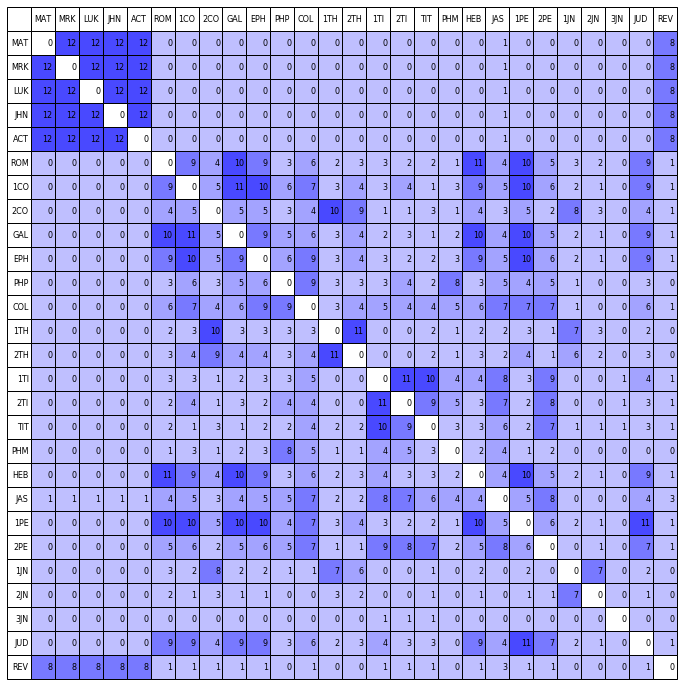

In [164]:
calculate_metric(lang_clusters, book_names)

# metric_table = calculate_metric(lang_clusters, book_names)
# with open(metric_path + 'experiment_1.txt', 'w') as w:
#     w.write("### Exp1 : Without data cleaning ###\n\n" )
#     w.write(str(metric_table))  

In [42]:
# Sum_of_squared_distances = []
# K = range(2,10)
# for k in K:
#     km = KMeans(n_clusters=k, max_iter=200, n_init=10)
#     km = km.fit(X)
#     Sum_of_squared_distances.append(km.inertia_)
    
# plt.plot(K, Sum_of_squared_distances, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Sum_of_squared_distances')
# plt.title('Elbow Method For Optimal k')
# plt.show()    

## Result 

In [ ]:
# lang ::  mandeali
# cluster :  0 ['3JN']
# cluster :  1 ['2PE', 'JUD']
# cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  3 ['2CO', '1TH', '2TH', '1JN', '2JN']
# cluster :  4 ['PHM']
# cluster :  5 ['ROM', '1CO', 'GAL', 'EPH', 'PHP', 'COL', '1TI', '2TI', 'TIT', 'HEB', 'JAS', '1PE']


# lang ::  haryanvi
# cluster :  0 ['1TI', '2TI', 'TIT', '2PE']
# cluster :  1 ['1JN', '2JN']
# cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  3 ['3JN']
# cluster :  4 ['ROM', '1CO', 'GAL', 'EPH', 'COL', 'PHM', 'HEB', '1PE', 'JUD']
# cluster :  5 ['2CO', 'PHP', '1TH', '2TH', 'JAS']


# lang ::  dogri
# cluster :  0 ['COL', '1TI', '2TI', 'TIT', '1PE', '2PE', '3JN', 'JUD']
# cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT']
# cluster :  2 ['ROM', '1CO', 'GAL', 'EPH', 'PHP', 'PHM', 'HEB', 'JAS']
# cluster :  3 ['REV']
# cluster :  4 ['2TH', '1JN', '2JN']
# cluster :  5 ['2CO', '1TH']


# lang ::  pahari_mahasui
# cluster :  0 ['1CO', 'EPH', 'PHP', 'COL', '1TI', '2TI', 'TIT', 'PHM', 'JAS', '1PE', '2PE', 'JUD']
# cluster :  1 ['2CO', '1TH', '2TH', '1JN']
# cluster :  2 ['ROM', 'GAL', 'HEB']
# cluster :  3 ['3JN']
# cluster :  4 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  5 ['2JN']


# lang ::  baghlayani
# cluster :  0 ['ROM', '1CO', 'GAL', 'HEB', '1PE', 'JUD']
# cluster :  1 ['EPH', 'PHP', 'COL', '2TI', 'PHM']
# cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  3 ['3JN']
# cluster :  4 ['1TI', 'TIT', 'JAS', '2PE', '2JN']
# cluster :  5 ['2CO', '1TH', '2TH', '1JN']


# lang ::  chambeali
# cluster :  0 ['1CO', 'PHP', 'COL', '1TI', '2TI', 'TIT', 'PHM', 'JAS', '1PE', '2PE', 'JUD']
# cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT']
# cluster :  2 ['ROM', 'GAL', 'EPH', 'HEB']
# cluster :  3 ['2CO', '1TH', '2TH', '1JN']
# cluster :  4 ['2JN', '3JN']
# cluster :  5 ['REV']


# lang ::  kulvi_outer_seraji
# cluster :  0 ['1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '2TH', 'JAS', '1PE', '2PE', 'JUD']
# cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  2 ['1TI', '2TI', 'TIT']
# cluster :  3 ['3JN']
# cluster :  4 ['PHM']
# cluster :  5 ['ROM', 'HEB', '1JN', '2JN']


# lang ::  gaddi
# cluster :  0 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '2TH', '1TI', '2TI', 'TIT', 'HEB', 'JAS', '1PE', '2PE', 'JUD']
# cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  2 ['2JN']
# cluster :  3 ['3JN']
# cluster :  4 ['1JN']
# cluster :  5 ['PHM']


# lang ::  bhadrawahi
# cluster :  0 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', 'HEB', 'JAS', '1PE', '1JN', '2JN']
# cluster :  1 ['PHM', '3JN']
# cluster :  2 ['1TH', '2TH']
# cluster :  3 ['REV']
# cluster :  4 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT']
# cluster :  5 ['1TI', '2TI', 'TIT', '2PE', 'JUD']


# lang ::  bilaspuri
# cluster :  0 ['3JN']
# cluster :  1 ['2CO', '1TH', '2TH', '1JN']
# cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  3 ['ROM', '1CO', 'GAL', 'EPH', 'PHP', 'COL', '1TI', '2TI', 'TIT', 'HEB', 'JAS', '1PE', '2PE', '2JN']
# cluster :  4 ['JUD']
# cluster :  5 ['PHM']


# lang ::  kulvi
# cluster :  0 ['1TI', '2TI', 'TIT', 'PHM', '2PE']
# cluster :  1 ['ROM', '1CO', 'GAL', 'EPH', 'PHP', 'COL', 'HEB', '1PE']
# cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'JAS', 'REV']
# cluster :  3 ['3JN']
# cluster :  4 ['2CO', '1TH', '2TH', '1JN', '2JN']
# cluster :  5 ['JUD']


# lang ::  kangri
# cluster :  0 ['PHM']
# cluster :  1 ['PHP', '1TI', '2TI', 'TIT', 'JAS', '2PE', '2JN']
# cluster :  2 ['ROM', '1CO', 'GAL', 'EPH', 'COL', '2TH', 'HEB', '1PE', 'JUD']
# cluster :  3 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  4 ['2CO', '1TH', '1JN']
# cluster :  5 ['3JN']
# calculate_metric(lang_clusters, book_names)
# ​

# Experiment 2

- Filtering stop words based on frequency
- Using k-means

## Finding word frequency threshold 

In [26]:
if 'stop_words' not in os.listdir(cwd):
    os.mkdir('stop_words')  
sw_path = cwd + 'stop_words/'

In [178]:
for lang in os.listdir(minority_path):
#     print("lang :: ", lang)
    words = []
    for book in sorted(os.listdir(minority_path + lang)):
        content = open(minority_path + lang + '/' + book, 'r').read()
        content = clean_text(content)
        words += content.split()
#     plot_words(words)
    

In [4]:
freq_thr = {'haryanvi':1350, 'dogri':1200, 'mandeali':1800, 'bilaspuri': 1500, 'kangri': 1600,
            'chambeali':500, 'kulvi':1000, 'baghlayani':1700, 'bhadrawahi':700, 
            'kulvi_outer_seraji': 1000, 'gaddi': 1000, 'pahari_mahasui':800}

## Filtering stop-words 

In [27]:
for lang in os.listdir(minority_path):
#     print("\nlang :: ", lang)
#     print("---------------------------------------------------")
    fp = open(sw_path + lang + '.txt', 'w')
    words = []
    for book in sorted(os.listdir(minority_path + lang)):
        content = open(minority_path + lang + '/' + book, 'r').read()
        content = clean_text(content)
        words += content.split()
    tokens_length = 0  
    temp = []
    for key, value in Counter(words).items():
        if value > freq_thr[lang]:
            tokens_length += len(key)
            temp.append(key)
    avg_len = tokens_length/len(temp)
    filtered_words = []
    for item in temp:
        if len(item)<=round(avg_len):
            filtered_words.append(item)
    fp.write('\n'.join(filtered_words))
    fp.close()

## clustering 

In [165]:
lang_clusters = {}
for lang in min_languages:
    print("\n\nlang :: ", lang)
    books = []
    book_content = []
    book_names = []
    for book in sorted(os.listdir(minority_path + lang)):
        book_names.append(book.split('_')[1][:3])
        stop_words = open(sw_path + lang + '.txt').readlines()
        stop_words = [item.strip() for item in stop_words]
        books.append(book.split('.')[0])
        content = open(minority_path + lang + '/' + book, 'r').read()
        content = clean_text(content) 
        words = [item for item in content.split() if item not in stop_words]
        content = ' '.join(words)
        book_content.append(content)
    df_clusters = cluster_books(books, book_content)
    lang_clusters[lang] = arrange_clusters(df_clusters)
    



lang ::  mandeali
cluster :  0 ['PHM']
cluster :  1 ['ROM', 'GAL', 'HEB']
cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT']
cluster :  3 ['1CO', 'EPH', 'PHP', 'COL', '1TI', '2TI', 'JAS', '1PE', '2PE', 'JUD', 'REV']
cluster :  4 ['3JN']
cluster :  5 ['2CO', '1TH', '2TH', 'TIT', '1JN', '2JN']


lang ::  haryanvi
cluster :  0 ['ROM', '1CO', 'GAL', 'EPH', 'PHP', 'COL', '2TH', '1TI', '2TI', 'TIT', 'PHM', 'HEB', 'JAS', '1PE', '2PE', 'JUD']
cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT']
cluster :  2 ['2CO', '1TH', '1JN']
cluster :  3 ['REV']
cluster :  4 ['2JN']
cluster :  5 ['3JN']


lang ::  dogri
cluster :  0 ['1CO', '2CO', 'EPH', 'PHP', 'COL', '1TH', '2TH', 'PHM', 'JAS']
cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT']
cluster :  2 ['3JN']
cluster :  3 ['1TI', '2TI', 'TIT', '1PE', '2PE', 'JUD']
cluster :  4 ['REV']
cluster :  5 ['ROM', 'GAL', 'HEB', '1JN', '2JN']


lang ::  pahari_mahasui
cluster :  0 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
cluster :  1 ['PHP', '2TI']
cluster :  2 [

## Metric 

color_groups : 
 {'0-3.0': '#BFBFFF', '3.0-6.0': '#A3A3FF', '6.0-9.0': '#7879FF', '9.0-12.0': '#4949FF'}


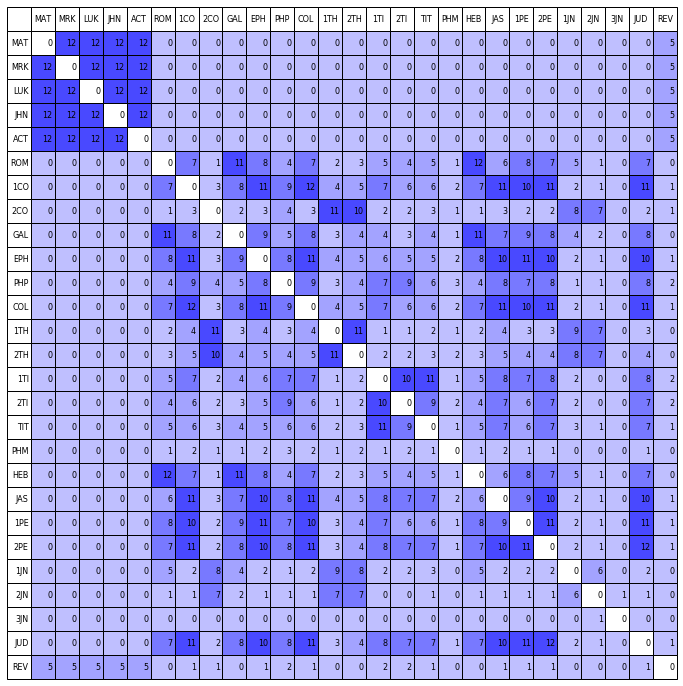

In [166]:
calculate_metric(lang_clusters, book_names)

# metric_table = calculate_metric(lang_clusters, book_names)
# with open(metric_path + 'experiment_2.txt', 'w') as w:
#     w.write("### Exp2 : Without stop words ###\n\n" )
#     w.write(str(metric_table))  

## Result 

In [9]:
# lang ::  mandeali
# cluster :  0 ['3JN']
# cluster :  1 ['ROM', '1CO', 'GAL', 'EPH', 'PHP', 'COL', '1TI', '2TI', 'TIT', 'HEB', 'JAS', '1PE', '2PE', '2JN', 'JUD']
# cluster :  2 ['REV']
# cluster :  3 ['PHM']
# cluster :  4 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT']
# cluster :  5 ['2CO', '1TH', '2TH', '1JN']


# lang ::  haryanvi
# cluster :  0 ['REV']
# cluster :  1 ['PHP', 'PHM']
# cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT']
# cluster :  3 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'COL', '1TH', '2TH', 'HEB', 'JAS', '1PE', '2PE', '1JN', 'JUD']
# cluster :  4 ['1TI', '2TI', 'TIT', '3JN']
# cluster :  5 ['2JN']


# lang ::  dogri
# cluster :  0 ['1TI', '2TI', 'TIT', '2PE', 'JUD']
# cluster :  1 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', 'PHM', 'HEB', 'JAS']
# cluster :  2 ['REV']
# cluster :  3 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT']
# cluster :  4 ['1TH', '2TH', '1PE', '1JN', '2JN']
# cluster :  5 ['3JN']


# lang ::  pahari_mahasui
# cluster :  0 ['2CO', '1TH', '2TH', '1JN', '2JN']
# cluster :  1 ['ROM', '1CO', 'GAL', 'EPH', 'PHP', 'COL', '1TI', '2TI', 'TIT', 'HEB', 'JAS', '1PE', 'JUD']
# cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  3 ['3JN']
# cluster :  4 ['2PE']
# cluster :  5 ['PHM']


# lang ::  baghlayani
# cluster :  0 ['GAL', 'HEB']
# cluster :  1 ['PHP', '2TI', 'PHM']
# cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  3 ['ROM', '1CO', 'EPH', 'COL', '1TI', 'TIT', 'JAS', '1PE', '2PE', 'JUD']
# cluster :  4 ['2CO', '1TH', '2TH', '1JN', '2JN']
# cluster :  5 ['3JN']


# lang ::  chambeali
# cluster :  0 ['PHP', 'COL', '2TH']
# cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT']
# cluster :  2 ['PHM']
# cluster :  3 ['3JN']
# cluster :  4 ['REV']
# cluster :  5 ['ROM', '1CO', '2CO', 'GAL', 'EPH', '1TH', '1TI', '2TI', 'TIT', 'HEB', 'JAS', '1PE', '2PE', '1JN', '2JN', 'JUD']


# lang ::  kulvi_outer_seraji
# cluster :  0 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  1 ['ROM', '1TI', '2TI', 'TIT', 'HEB', '1JN']
# cluster :  2 ['1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '2TH', 'JAS', '1PE', '2PE', 'JUD']
# cluster :  3 ['3JN']
# cluster :  4 ['2JN']
# cluster :  5 ['PHM']


# lang ::  gaddi
# cluster :  0 ['JUD']
# cluster :  1 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '2TH', '1TI', '2TI', 'TIT', 'HEB', 'JAS', '1PE', '2PE', '1JN']
# cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  3 ['3JN']
# cluster :  4 ['PHM']
# cluster :  5 ['2JN']


# lang ::  bhadrawahi
# cluster :  0 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '2TH', 'HEB', 'JAS', '1PE', '1JN', '2JN']
# cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT']
# cluster :  2 ['3JN']
# cluster :  3 ['PHM']
# cluster :  4 ['REV']
# cluster :  5 ['1TI', '2TI', 'TIT', '2PE', 'JUD']


# lang ::  bilaspuri
# cluster :  0 ['PHM']
# cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  2 ['PHP', '1TI', '2TI', 'TIT', '2PE', 'JUD']
# cluster :  3 ['ROM', '1CO', 'GAL', 'EPH', 'COL', '2TH', 'HEB', 'JAS', '1PE']
# cluster :  4 ['3JN']
# cluster :  5 ['2CO', '1TH', '1JN', '2JN']


# lang ::  kulvi
# cluster :  0 ['ROM', '1CO', 'GAL', 'EPH', 'PHP', 'COL', '2TH', '2TI', 'HEB', '1PE', 'JUD']
# cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'JAS', 'REV']
# cluster :  2 ['3JN']
# cluster :  3 ['PHM']
# cluster :  4 ['2CO', '1TH', '1JN', '2JN']
# cluster :  5 ['1TI', 'TIT', '2PE']


# lang ::  kangri
# cluster :  0 ['ROM', '1CO', 'GAL', 'EPH', 'PHP', 'COL', 'HEB', '1PE', '2PE', 'JUD']
# cluster :  1 ['2CO', '1TH', '2TH', 'PHM', '1JN']
# cluster :  2 ['3JN']
# cluster :  3 ['1TI', '2TI', 'TIT', 'JAS']
# cluster :  4 ['2JN']
# cluster :  5 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']

# Experiment 3

- Removing stop words
- Using unique words only
- K- means

In [167]:
lang_clusters = {}
for lang in min_languages:
    print("\n\nlang :: ", lang)
    books = []
    book_content = []
    book_names = []
    for book in sorted(os.listdir(minority_path + lang)):
        book_names.append(book.split('_')[1][:3])
        stop_words = open(sw_path + lang + '.txt').readlines()
        stop_words = [item.strip() for item in stop_words]
        books.append(book.split('.')[0])
        content = open(minority_path + lang + '/' + book, 'r').read()
        content = clean_text(content) 
        words = [item for item in list(set(content.split())) if item not in stop_words]
        content = ' '.join(words)
        book_content.append(content)
    df_clusters = cluster_books(books, book_content)
    lang_clusters[lang] = arrange_clusters(df_clusters)



lang ::  mandeali
cluster :  0 ['JUD']
cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
cluster :  2 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '2TH', '1TI', '2TI', 'HEB', 'JAS', '1PE', '2PE', '1JN']
cluster :  3 ['PHM']
cluster :  4 ['TIT']
cluster :  5 ['2JN', '3JN']


lang ::  haryanvi
cluster :  0 ['PHM', '2JN', '3JN']
cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
cluster :  2 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TI', '2TI', 'TIT', 'HEB', 'JAS', '1PE', '1JN']
cluster :  3 ['1TH', '2TH']
cluster :  4 ['JUD']
cluster :  5 ['2PE']


lang ::  dogri
cluster :  0 ['2TH', '2TI', '2PE']
cluster :  1 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '1TI', 'TIT', 'HEB', '1PE', '1JN']
cluster :  2 ['2JN', '3JN']
cluster :  3 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'JAS', 'REV']
cluster :  4 ['JUD']
cluster :  5 ['PHM']


lang ::  pahari_mahasui
cluster :  0 ['2TI']
cluster :  1 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '1TI', 

## Metric 

color_groups : 
 {'0-3.0': '#BFBFFF', '3.0-6.0': '#A3A3FF', '6.0-9.0': '#7879FF', '9.0-12.0': '#4949FF'}


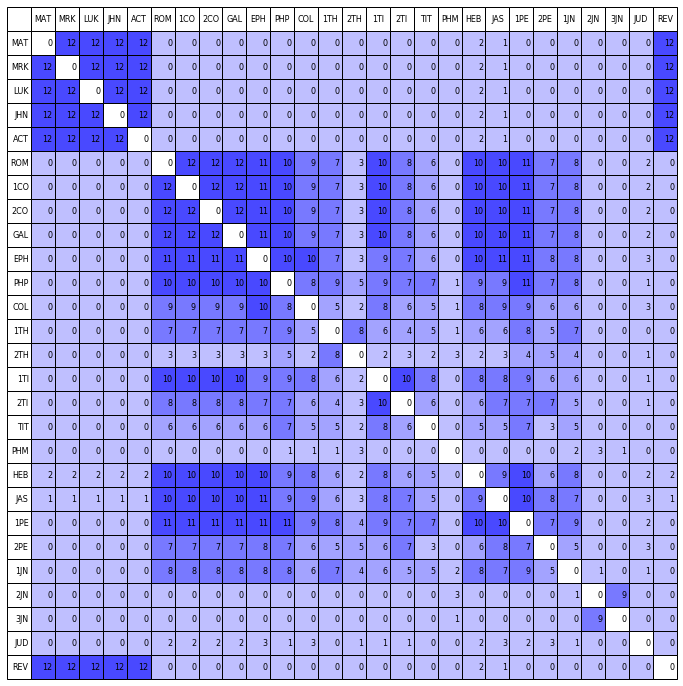

In [168]:
calculate_metric(lang_clusters, book_names)

# metric_table = calculate_metric(lang_clusters, book_names)
# with open(metric_path + 'experiment_3.txt', 'w') as w:
#     w.write("### Exp 3: Unique words and without stop words ###\n\n")
#     w.write(str(metric_table))  

## Result 

In [ ]:
# lang ::  mandeali
# cluster :  0 ['PHP', 'COL', '1TH', '2TH']
# cluster :  1 ['EPH', 'TIT', '1PE', '1JN', 'JUD']
# cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  3 ['2JN', '3JN']
# cluster :  4 ['PHM']
# cluster :  5 ['ROM', '1CO', '2CO', 'GAL', '1TI', '2TI', 'HEB', 'JAS', '2PE']


# lang ::  haryanvi
# cluster :  0 ['2TH']
# cluster :  1 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '1TI', '2TI', 'TIT', 'HEB', 'JAS', '1PE', '1JN']
# cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  3 ['JUD']
# cluster :  4 ['2PE']
# cluster :  5 ['PHM', '2JN', '3JN']


# lang ::  dogri
# cluster :  0 ['1TI', '2TI', 'TIT', 'PHM', 'JUD']
# cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  2 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', 'HEB', 'JAS', '1PE']
# cluster :  3 ['2PE']
# cluster :  4 ['2JN', '3JN']
# cluster :  5 ['2TH', '1JN']


# lang ::  pahari_mahasui
# cluster :  0 ['2JN']
# cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  2 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TI', '2TI', 'TIT', 'HEB', 'JAS', '1PE', '2PE']
# cluster :  3 ['1TH', '2TH', '1JN', 'JUD']
# cluster :  4 ['PHM']
# cluster :  5 ['3JN']


# lang ::  baghlayani
# cluster :  0 ['EPH', 'COL', '2TH', '1PE', 'JUD']
# cluster :  1 ['2JN', '3JN']
# cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'HEB', 'REV']
# cluster :  3 ['1TI', '2TI', 'TIT']
# cluster :  4 ['ROM', '1CO', '2CO', 'GAL', 'PHP', '1TH', 'JAS', '2PE', '1JN']
# cluster :  5 ['PHM']


# lang ::  chambeali
# cluster :  0 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  1 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '1TI', '2TI', 'TIT', 'HEB', 'JAS', '1PE', '1JN']
# cluster :  2 ['2TH']
# cluster :  3 ['2JN', '3JN']
# cluster :  4 ['2PE', 'JUD']
# cluster :  5 ['PHM']


# lang ::  kulvi_outer_seraji
# cluster :  0 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  1 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'COL', '1TI', '2TI', 'TIT', 'HEB', 'JAS', '1PE']
# cluster :  2 ['PHM', '2JN']
# cluster :  3 ['2PE', 'JUD']
# cluster :  4 ['PHP', '1TH', '2TH', '1JN']
# cluster :  5 ['3JN']


# lang ::  gaddi
# cluster :  0 ['TIT']
# cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  2 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'COL', '1TI', '2TI', 'HEB', 'JAS', '1PE', '2PE', '1JN', 'JUD']
# cluster :  3 ['PHP', '1TH', '2TH']
# cluster :  4 ['2JN', '3JN']
# cluster :  5 ['PHM']


# lang ::  bhadrawahi
# cluster :  0 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  1 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TI', 'HEB', '1PE', '2PE', 'JUD']
# cluster :  2 ['2JN', '3JN']
# cluster :  3 ['1TH', '2TH', 'JAS', '1JN']
# cluster :  4 ['2TI', 'TIT']
# cluster :  5 ['PHM']


# lang ::  bilaspuri
# cluster :  0 ['3JN']
# cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'HEB', 'REV']
# cluster :  2 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '2TH', '1TI', '2TI', 'TIT', 'JAS', '1PE', '1JN']
# cluster :  3 ['2JN']
# cluster :  4 ['2PE', 'JUD']
# cluster :  5 ['PHM']


# lang ::  kulvi
# cluster :  0 ['1JN']
# cluster :  1 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TI', '2TI', 'TIT', 'HEB', 'JAS', '1PE', '2PE', 'JUD']
# cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  3 ['PHM']
# cluster :  4 ['2JN', '3JN']
# cluster :  5 ['1TH', '2TH']


# lang ::  kangri
# cluster :  0 ['1TH', '2TH', 'PHM', '1JN']
# cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'HEB', 'REV']
# cluster :  2 ['2JN', '3JN']
# cluster :  3 ['1TI', 'TIT']
# cluster :  4 ['2PE', 'JUD']
# cluster :  5 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '2TI', 'JAS', '1PE']

# Experiment 4

- Using gateway languages as input
- Removing stop words and using unique words only
- k-means clustering

In [24]:
''' Parsing usfm files '''

for gl in os.listdir(gl_path):
#     print(gl)
    if not gl=='english':
        continue
    for book in os.listdir(gl_path + gl):
        os.system("usfm-grammar "+gl_path+gl+'/'+book+" -o csv >> "+gl_path+gl+'/'+book+".csv")  

In [4]:
for lang in gl_languages:
    if lang in ['urdu', 'odiya', 'english']:
        continue   
    print(lang)
    for book in os.listdir(gl_path + lang):
        if book.endswith('csv'):
            name = book.split('.')[0]
            fp = open(gl_path + lang+'/'+name + '.txt', 'w')
            df = pd.read_csv(gl_path + lang+'/'+book)
            df = df.dropna()
            fp.write('\n'.join(list(df[' Text'])))
            fp.close() 

punjabi
malayalam
telegu
kannada
bengali
marathi
tamil
gujarati
hindi
assamese


lang ::  punjabi


/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2565 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2596 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2631 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2598 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2600 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211:

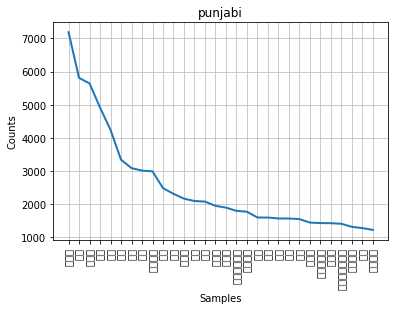

lang ::  malayalam


/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3342 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3368 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3405 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3393 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3358 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211:

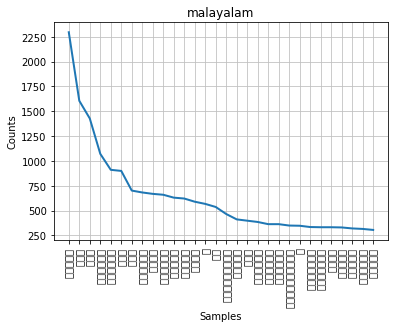

lang ::  telegu


/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3078 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3119 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3112 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3077 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3135 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211:

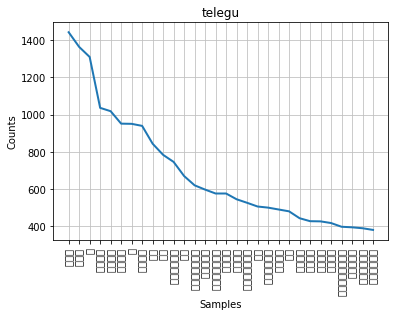

lang ::  kannada


/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3214 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3202 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3238 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3265 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3206 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211:

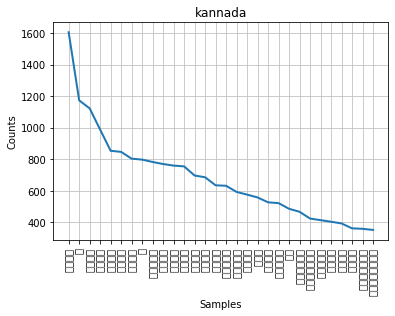

lang ::  odiya


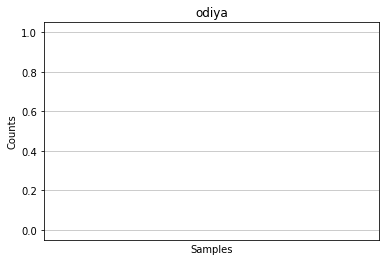

lang ::  bengali


/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2447 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2476 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2434 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2472 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2494 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211:

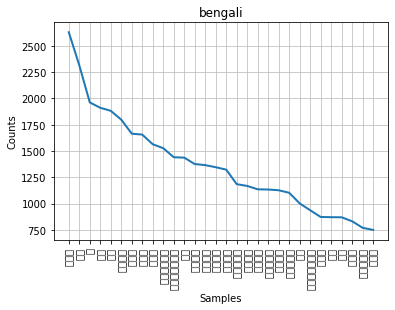

lang ::  marathi


/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2310 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2339 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2367 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2375 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211:

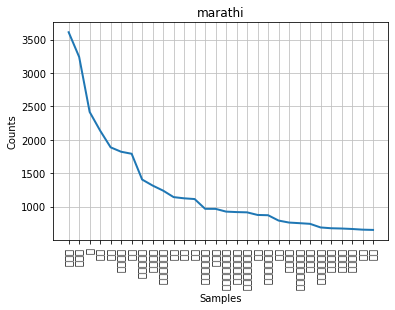

lang ::  tamil


/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2958 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2985 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3021 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2993 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3009 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211:

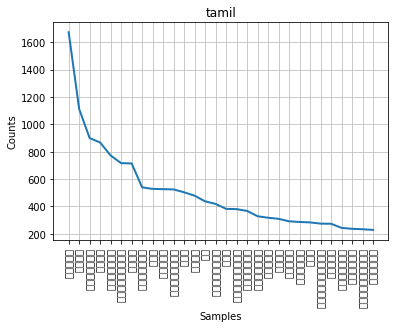

lang ::  gujarati


/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2715 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2759 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2709 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2724 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2693 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211:

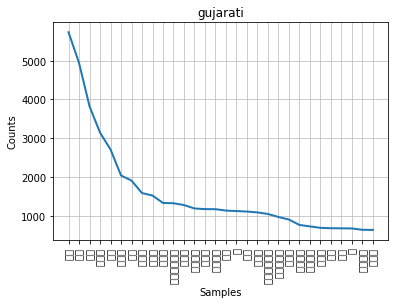

lang ::  hindi


/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2352 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2325 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2375 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211:

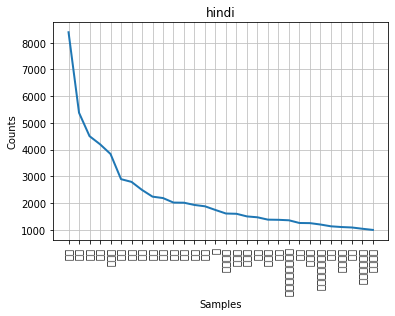

lang ::  assamese


/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2438 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2544 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2497 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2488 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2503 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211:

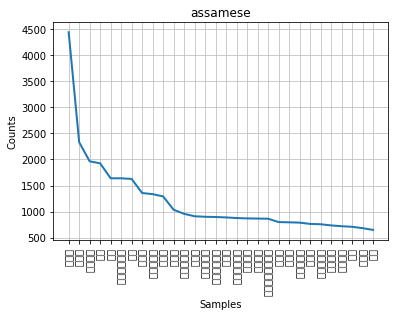

lang ::  urdu


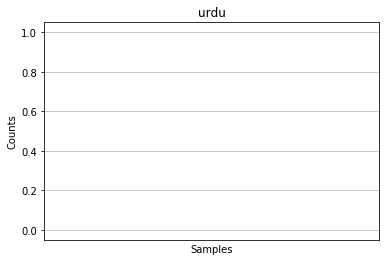

In [45]:
for lang in os.listdir(gl_path):
    print("lang :: ", lang)
    words = []
    for book in sorted(os.listdir(gl_path + lang)):
        if not book.endswith('txt'):
            continue
#         print(book)
        content = open(gl_path + lang + '/' + book, 'r').read()
        content = clean_text(content)
        words += content.split()
    
    fdist = FreqDist(words)
    fdist.plot(30,title=lang)

In [24]:
freq_thr = {'punjabi':1500, 'malayalam':200, 'telegu':400, 'kannada': 300, 'odiya':1100 ,
            'bengali':700, 'marathi':500, 'tamil':300, 'gujarati':800, 
            'hindi':1200 , 'assamese':600 , 'urdu':1000}

In [26]:
for lang in os.listdir(gl_path):
#     print("\nlang :: ", lang)
#     print("---------------------------------------------------")
    if lang in ['urdu', 'odiya', 'english']:
        continue
    fp = open(sw_path + lang + '.txt', 'w')
    words = []
    for book in sorted(os.listdir(gl_path + lang)):
        if not book.endswith('txt'):
            continue    
        content = open(gl_path + lang + '/' + book, 'r').read()
        content = clean_text(content)
        words += content.split()
    tokens_length = 0  
    temp = []
    for key, value in Counter(words).items():
        if value > freq_thr[lang]:
            tokens_length += len(key)
            temp.append(key)        
    avg_len = tokens_length/len(temp)
    filtered_words = []
    for item in temp:
        if len(item)<=round(avg_len):
            filtered_words.append(item)
#     print(len(filtered_words))        
    fp.write('\n'.join(filtered_words))
    fp.close()

## Clustering 

In [171]:
lang_clusters = {}
for lang in gl_languages:
    print("\n\nlang :: ", lang)
    if lang in ['urdu', 'odiya','english']:
        continue
    books = []
    book_content = []
    book_names = []
    for book in sorted(os.listdir(gl_path+lang)):
        if not book.endswith('txt'):
            continue 
        book_names.append(book.split('_')[1][:3])
        stop_words = open(sw_path + lang + '.txt').readlines()
        stop_words = [item.strip() for item in stop_words]
        books.append(book.split('.')[0])
        content = open(gl_path + lang + '/' + book, 'r').read()
        content = clean_text(content) 
        words = [item for item in list(set(content.split())) if item not in stop_words]
        content = ' '.join(words)
        book_content.append(content)
    df_clusters = cluster_books(books, book_content)
    lang_clusters[lang] = arrange_clusters(df_clusters)



lang ::  english


lang ::  punjabi
cluster :  0 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TI', '2TI', 'TIT', 'HEB', 'JAS', '1PE']
cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
cluster :  2 ['2PE', 'JUD']
cluster :  3 ['1TH', '2TH', '1JN']
cluster :  4 ['PHM']
cluster :  5 ['2JN', '3JN']


lang ::  malayalam
cluster :  0 ['TIT']
cluster :  1 ['ROM', '1CO', 'GAL', 'EPH', '1TI', '2TI', 'HEB', 'JAS', '1PE', '2PE', '1JN', 'JUD']
cluster :  2 ['2JN']
cluster :  3 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
cluster :  4 ['2CO', 'PHP', 'COL', '1TH', '2TH', '3JN']
cluster :  5 ['PHM']


lang ::  telegu
cluster :  0 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
cluster :  1 ['HEB', '1PE']
cluster :  2 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '2TH', '1TI', '2TI', 'TIT', 'PHM', 'JAS', '2PE']
cluster :  3 ['3JN']
cluster :  4 ['JUD']
cluster :  5 ['1JN', '2JN']


lang ::  kannada
cluster :  0 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'ROM', '1CO', '2CO', 'GAL', 'PHP', '

## Metric 

color_groups : 
 {'0-2.5': '#BFBFFF', '2.5-5.0': '#A3A3FF', '5.0-7.5': '#7879FF', '7.5-10.0': '#4949FF'}


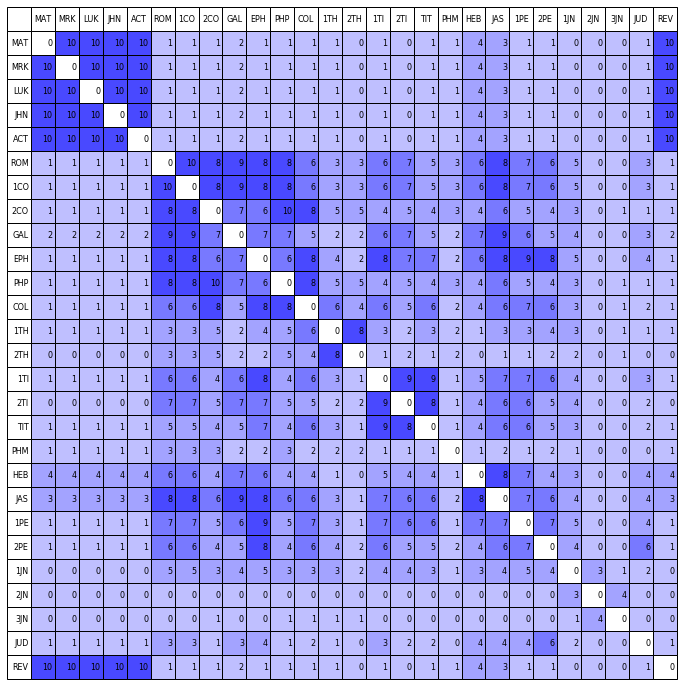

In [172]:
calculate_metric(lang_clusters, book_names)

# metric_table = calculate_metric(lang_clusters, book_names)
# with open(metric_path + 'experiment_4.txt', 'w') as w:
#     w.write("### Exp4 : GL (unique words, without stop words) ###\n\n" )
#     w.write(str(metric_table))

## Result 

In [50]:
# lang ::  tamil
# cluster :  0 ['ROM', '1CO', '2CO', 'GAL', '2TH', '2TI', 'JAS']
# cluster :  1 ['PHM']
# cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'EPH', 'COL', '1TH', '1TI', 'TIT', 'HEB', '1PE', '2PE', 'JUD', 'REV']
# cluster :  3 ['2JN']
# cluster :  4 ['3JN']
# cluster :  5 ['PHP', '1JN']


# lang ::  urdu


# lang ::  odiya


# lang ::  punjabi
# cluster :  0 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '2TH', '1TI', '2TI', 'TIT', 'JAS', '1PE', '2PE', '1JN']
# cluster :  1 ['2JN']
# cluster :  2 ['PHM']
# cluster :  3 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'HEB', 'REV']
# cluster :  4 ['JUD']
# cluster :  5 ['3JN']


# lang ::  hindi
# cluster :  0 ['JUD']
# cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'HEB', 'REV']
# cluster :  2 ['2JN', '3JN']
# cluster :  3 ['PHM']
# cluster :  4 ['2CO', 'PHP', '1TH', '2TH', 'JAS', '1PE', '1JN']
# cluster :  5 ['ROM', '1CO', 'GAL', 'EPH', 'COL', '1TI', '2TI', 'TIT', '2PE']


# lang ::  gujarati
# cluster :  0 ['JAS']
# cluster :  1 ['2JN', '3JN']
# cluster :  2 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '2TH', '1TI', 'TIT', 'HEB', '1PE', '2PE', '1JN', 'JUD']
# cluster :  3 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  4 ['PHM']
# cluster :  5 ['2TI']


# lang ::  malayalam
# cluster :  0 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'GAL', '1TI', '2TI', 'JAS', 'REV']
# cluster :  1 ['ROM', '1CO', '2CO', 'EPH', 'PHP', 'COL', '1TH', '2TH', 'TIT', 'HEB', '1PE', '2PE']
# cluster :  2 ['3JN']
# cluster :  3 ['PHM']
# cluster :  4 ['JUD']
# cluster :  5 ['1JN', '2JN']


# lang ::  marathi
# cluster :  0 ['2PE']
# cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'HEB', 'JUD', 'REV']
# cluster :  2 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '2TH', '1TI', '2TI', 'TIT', 'JAS', '1PE', '1JN']
# cluster :  3 ['2JN']
# cluster :  4 ['PHM']
# cluster :  5 ['3JN']


# lang ::  telegu
# cluster :  0 ['2TH']
# cluster :  1 ['EPH', 'COL', '1TH', '1TI', '2TI', 'TIT', '1PE', 'JUD']
# cluster :  2 ['2JN']
# cluster :  3 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'ROM', '1CO', '2CO', 'GAL', 'PHP', 'HEB', 'JAS', '2PE', '1JN', 'REV']
# cluster :  4 ['PHM']
# cluster :  5 ['3JN']


# lang ::  kannada
# cluster :  0 ['2TI', 'TIT']
# cluster :  1 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '2TH', '1TI', 'HEB', 'JAS', '1PE', '2PE', '1JN', 'JUD']
# cluster :  2 ['PHM']
# cluster :  3 ['3JN']
# cluster :  4 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  5 ['2JN']


# lang ::  assamese
# cluster :  0 ['1JN', '2JN', '3JN']
# cluster :  1 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '2TH', '1TI', '2TI', 'HEB', 'JAS', '1PE', '2PE']
# cluster :  2 ['JUD']
# cluster :  3 ['TIT']
# cluster :  4 ['PHM']
# cluster :  5 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']


# lang ::  bengali
# cluster :  0 ['EPH', 'COL', '2TH', '2TI', 'TIT', 'JAS', '1PE', '1JN', 'JUD']
# cluster :  1 ['3JN']
# cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  3 ['PHM']
# cluster :  4 ['2JN']
# cluster :  5 ['ROM', '1CO', '2CO', 'GAL', 'PHP', '1TH', '1TI', 'HEB', '2PE']

# Metric on unique words 

- Calculating a metric for unique words across 27 NT books

In [173]:
def plot_single_words(lang, path):
    print("\n\nPloting single word counts :", lang)
#     for lang in languages:
    book_names = []
    book_words = {}
    for book in sorted(os.listdir(path+lang)):
        if not book.endswith('txt'):
            continue
        name = book.split('_')[1][:3]
        book_names.append(name)
        stop_words = open(sw_path + lang + '.txt').readlines()
        stop_words = [item.strip() for item in stop_words]
        content = open(path + lang + '/' + book, 'r').read()
        content = clean_text(content) 
        words = [item for item in list(set(content.split())) if item not in stop_words]
        book_words[name] = words
    table = calculate_metric_words(book_names, book_words)  
#         with open(metric_path + 'metric_words/single_words/'+lang+'.txt', 'w') as w:
#             w.write(str(table)) 

 - Calculating metric for unique words (3 grams) across 27 NT books

In [174]:
def plot_3_grams(lang, path):
    print("\n\nPloting 3-gram counts :", lang)
#     for lang in languages:
#     print("\n\n language: ", lang)
    book_names = []
    book_words = {}
    for book in sorted(os.listdir(path+lang)):
        if not book.endswith('txt'):
            continue
        name = book.split('_')[1][:3]
        book_names.append(name)
#         stop_words = open(sw_path + min_lang + '.txt').readlines()
#         stop_words = [item.strip() for item in stop_words]
        content = open(path + lang + '/' + book, 'r').read()
        content = clean_text(content) 
#         words = [item for item in list(set(content.split())) if item not in stop_words]
        three_grams = ngrams(content.split(), 3)
        book_words[name] = list(set(list(three_grams)))
    table = calculate_metric_words(book_names, book_words)  
#         with open(metric_path + 'metric_words/3gram_words/'+lang+'.txt', 'w') as w:
#             w.write(str(table))

In [54]:
if 'metric_words' not in os.listdir(metric_path):
    os.mkdir(metric_path + 'metric_words')
if 'single_words' not in os.listdir(metric_path+'metric_words'):
    os.mkdir(metric_path + 'metric_words/single_words')

## Minority languages 

- Calculating  metric for unique words (3 grams) across 27 NT books

mandeali


Ploting single word counts : mandeali
color_groups : 
 {'0-472.75': '#BFBFFF', '472.75-945.5': '#A3A3FF', '945.5-1418.25': '#7879FF', '1418.25-1891.0': '#4949FF'}


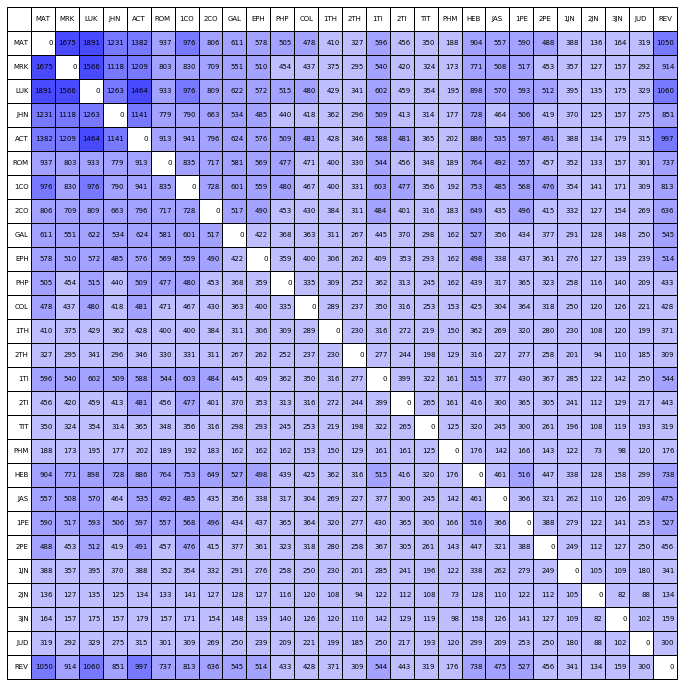



Ploting 3-gram counts : mandeali
color_groups : 
 {'0-1355.5': '#BFBFFF', '1355.5-2711.0': '#A3A3FF', '2711.0-4066.5': '#7879FF', '4066.5-5422.0': '#4949FF'}


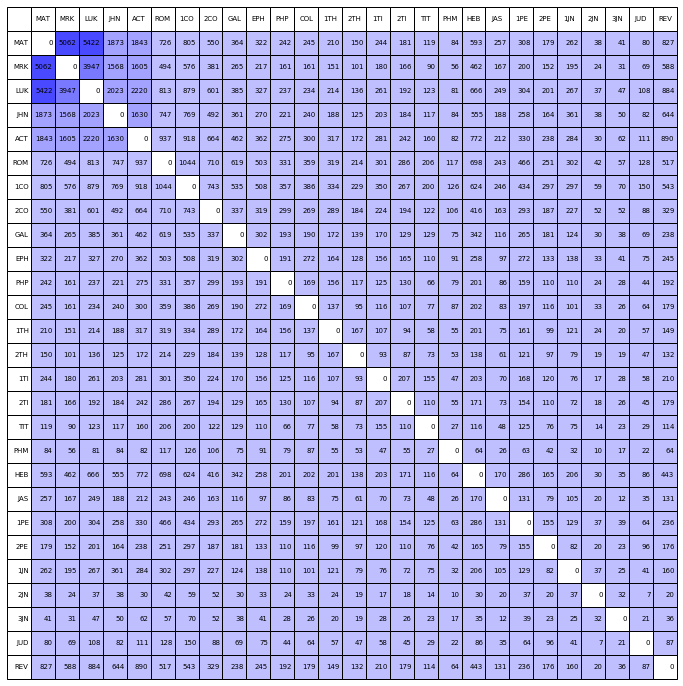

haryanvi


Ploting single word counts : haryanvi
color_groups : 
 {'0-474.25': '#BFBFFF', '474.25-948.5': '#A3A3FF', '948.5-1422.75': '#7879FF', '1422.75-1897.0': '#4949FF'}


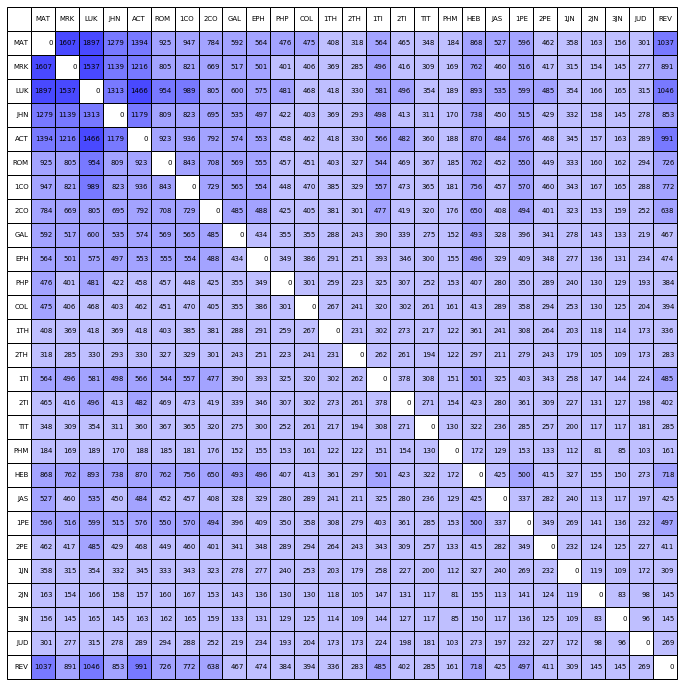



Ploting 3-gram counts : haryanvi
color_groups : 
 {'0-980.5': '#BFBFFF', '980.5-1961.0': '#A3A3FF', '1961.0-2941.5': '#7879FF', '2941.5-3922.0': '#4949FF'}


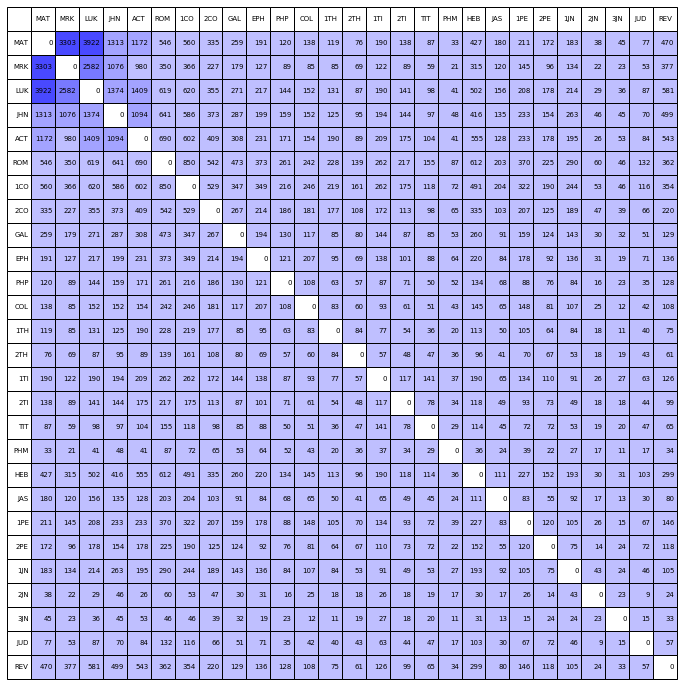

dogri


Ploting single word counts : dogri
color_groups : 
 {'0-427.5': '#BFBFFF', '427.5-855.0': '#A3A3FF', '855.0-1282.5': '#7879FF', '1282.5-1710.0': '#4949FF'}


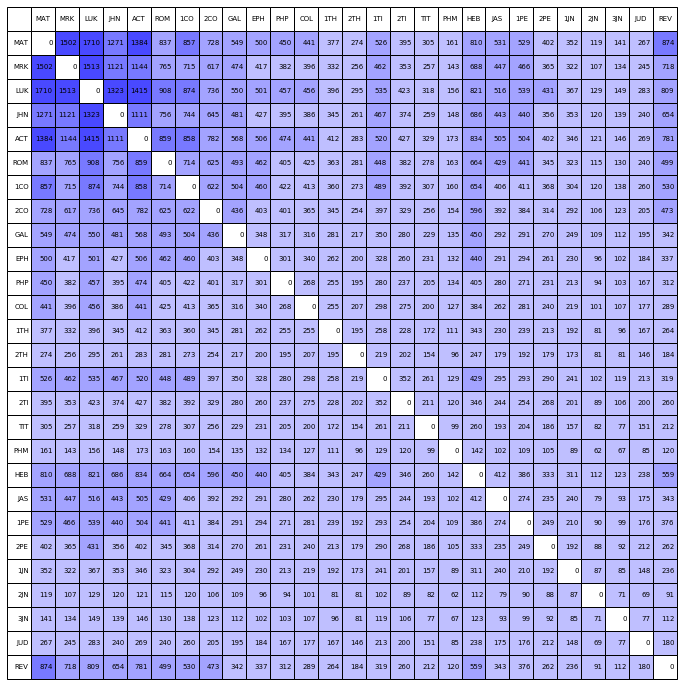



Ploting 3-gram counts : dogri
color_groups : 
 {'0-522.25': '#BFBFFF', '522.25-1044.5': '#A3A3FF', '1044.5-1566.75': '#7879FF', '1566.75-2089.0': '#4949FF'}


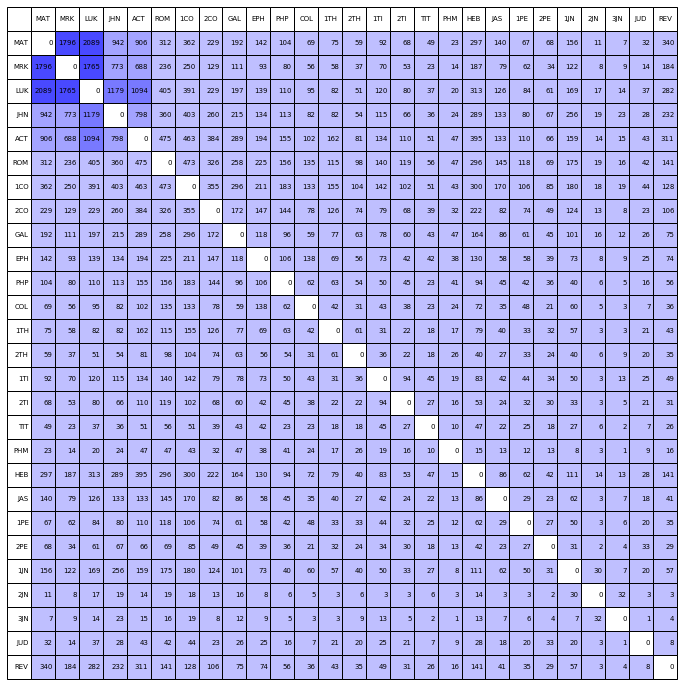

pahari_mahasui


Ploting single word counts : pahari_mahasui
color_groups : 
 {'0-454.25': '#BFBFFF', '454.25-908.5': '#A3A3FF', '908.5-1362.75': '#7879FF', '1362.75-1817.0': '#4949FF'}


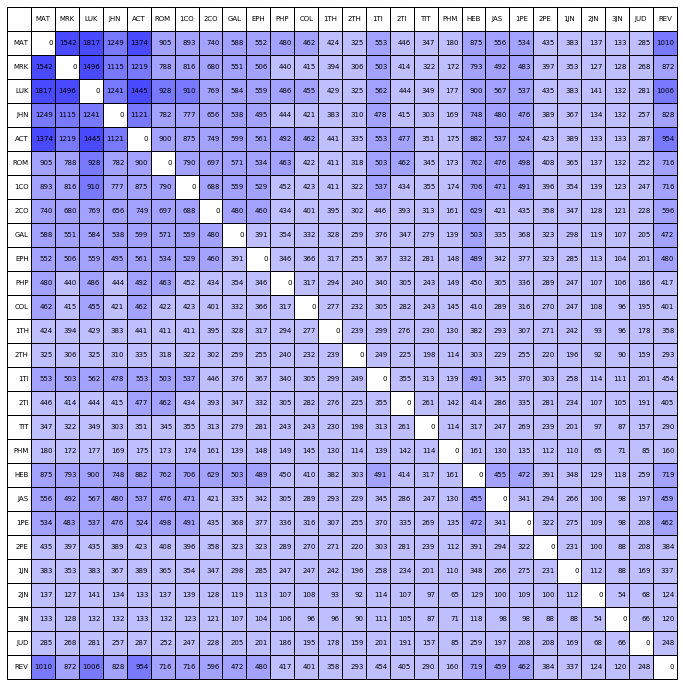



Ploting 3-gram counts : pahari_mahasui
color_groups : 
 {'0-972.25': '#BFBFFF', '972.25-1944.5': '#A3A3FF', '1944.5-2916.75': '#7879FF', '2916.75-3889.0': '#4949FF'}


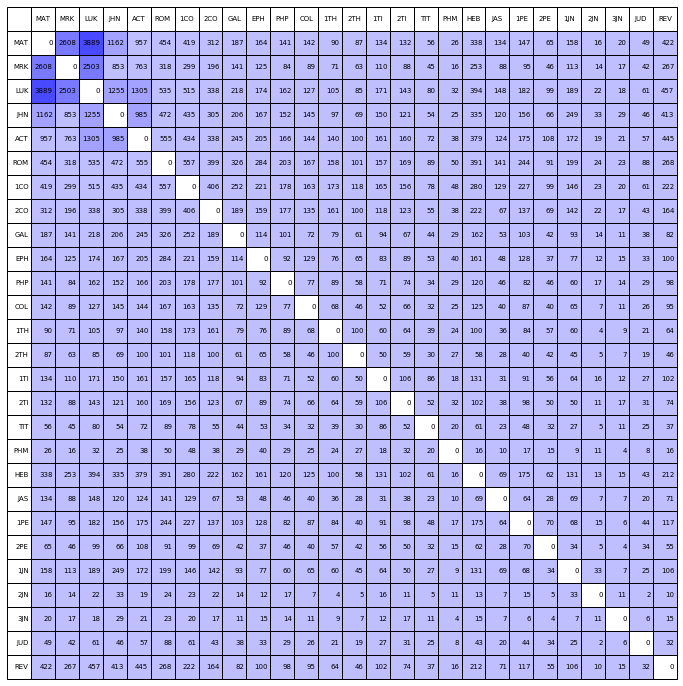

baghlayani


Ploting single word counts : baghlayani
color_groups : 
 {'0-465.5': '#BFBFFF', '465.5-931.0': '#A3A3FF', '931.0-1396.5': '#7879FF', '1396.5-1862.0': '#4949FF'}


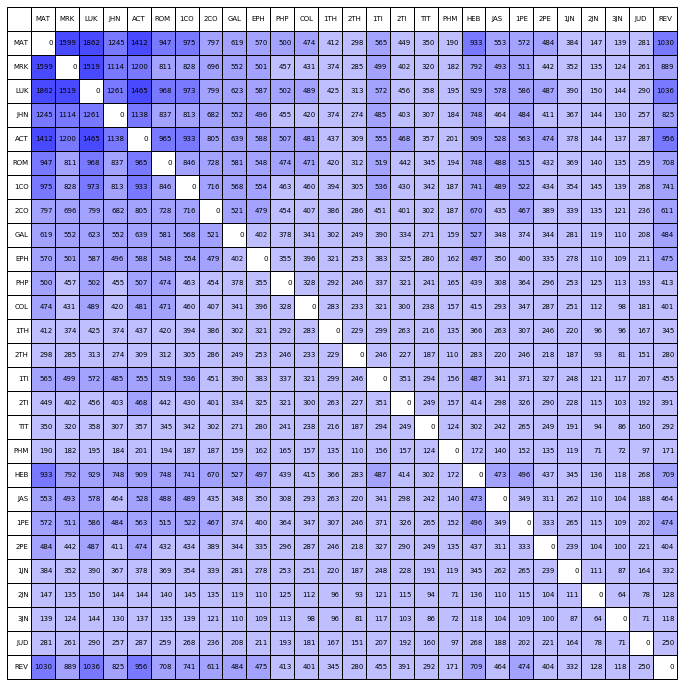



Ploting 3-gram counts : baghlayani
color_groups : 
 {'0-1052.25': '#BFBFFF', '1052.25-2104.5': '#A3A3FF', '2104.5-3156.75': '#7879FF', '3156.75-4209.0': '#4949FF'}


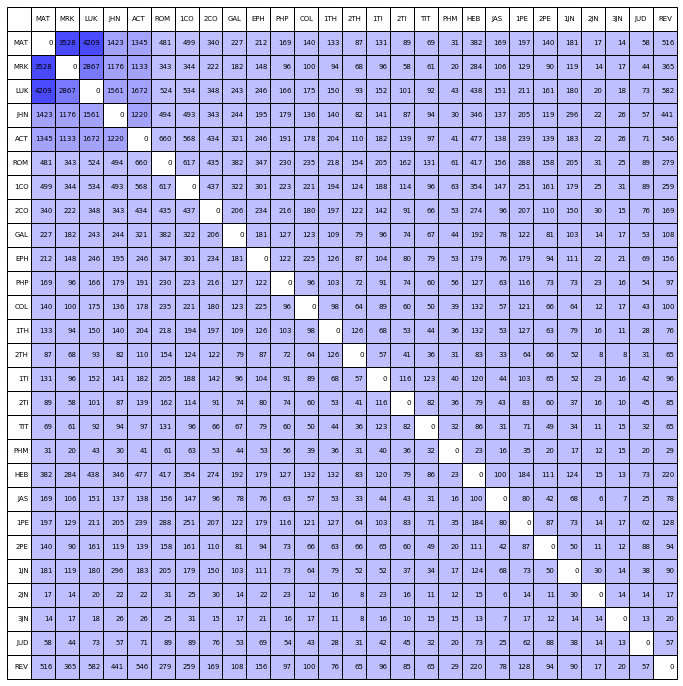

chambeali


Ploting single word counts : chambeali
color_groups : 
 {'0-383.0': '#BFBFFF', '383.0-766.0': '#A3A3FF', '766.0-1149.0': '#7879FF', '1149.0-1532.0': '#4949FF'}


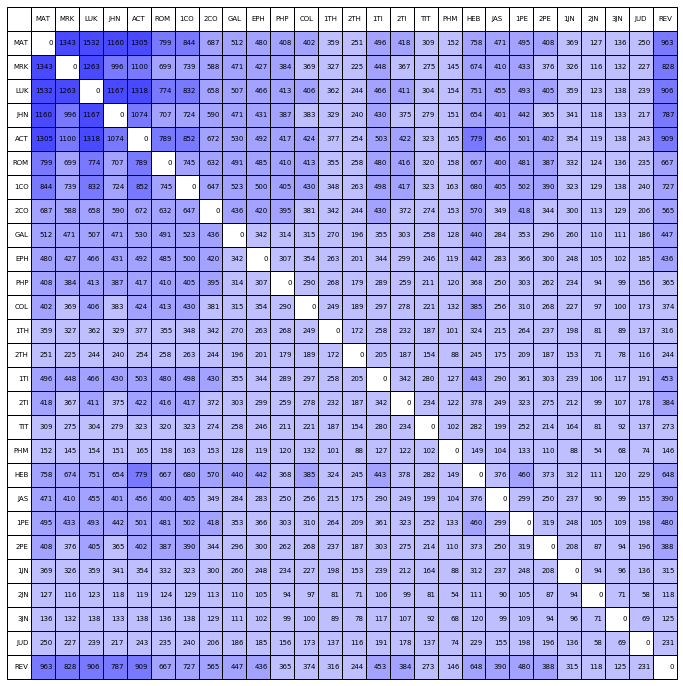



Ploting 3-gram counts : chambeali
color_groups : 
 {'0-701.25': '#BFBFFF', '701.25-1402.5': '#A3A3FF', '1402.5-2103.75': '#7879FF', '2103.75-2805.0': '#4949FF'}


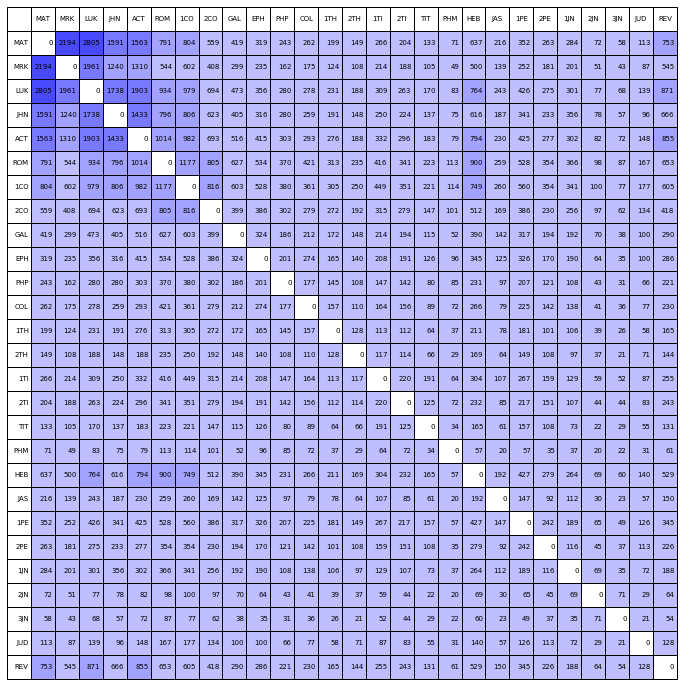

kulvi_outer_seraji


Ploting single word counts : kulvi_outer_seraji
color_groups : 
 {'0-489.5': '#BFBFFF', '489.5-979.0': '#A3A3FF', '979.0-1468.5': '#7879FF', '1468.5-1958.0': '#4949FF'}


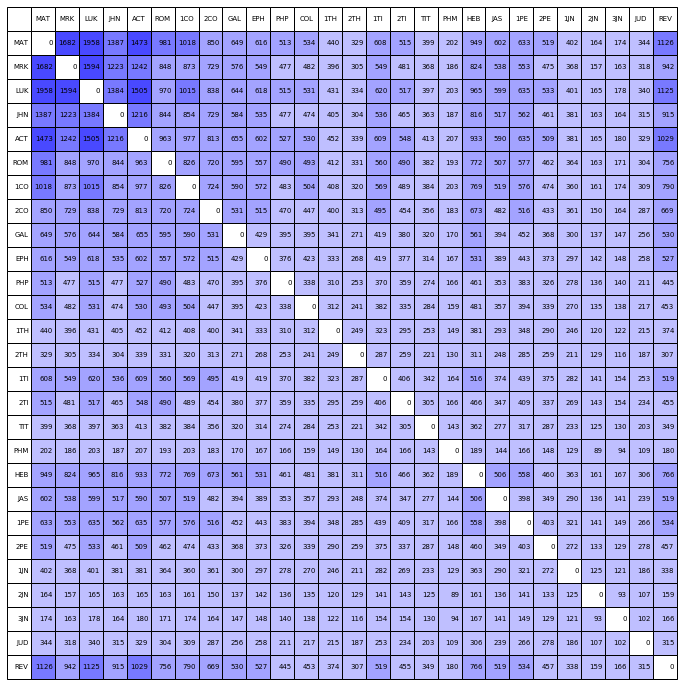



Ploting 3-gram counts : kulvi_outer_seraji
color_groups : 
 {'0-1200.75': '#BFBFFF', '1200.75-2401.5': '#A3A3FF', '2401.5-3602.25': '#7879FF', '3602.25-4803.0': '#4949FF'}


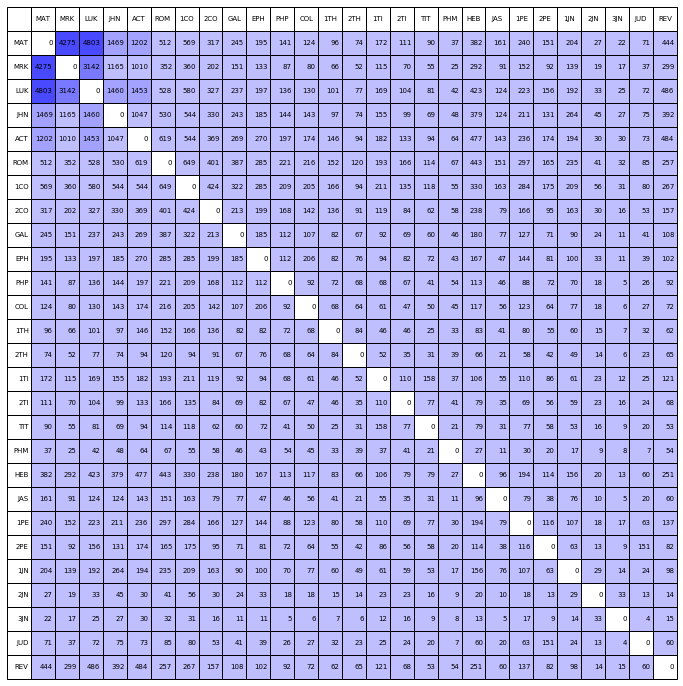

gaddi


Ploting single word counts : gaddi
color_groups : 
 {'0-451.25': '#BFBFFF', '451.25-902.5': '#A3A3FF', '902.5-1353.75': '#7879FF', '1353.75-1805.0': '#4949FF'}


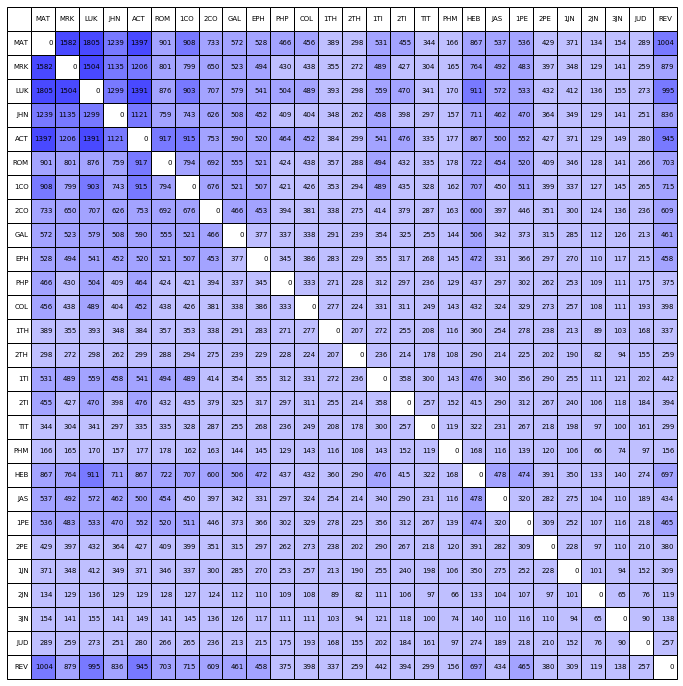



Ploting 3-gram counts : gaddi
color_groups : 
 {'0-799.25': '#BFBFFF', '799.25-1598.5': '#A3A3FF', '1598.5-2397.75': '#7879FF', '2397.75-3197.0': '#4949FF'}


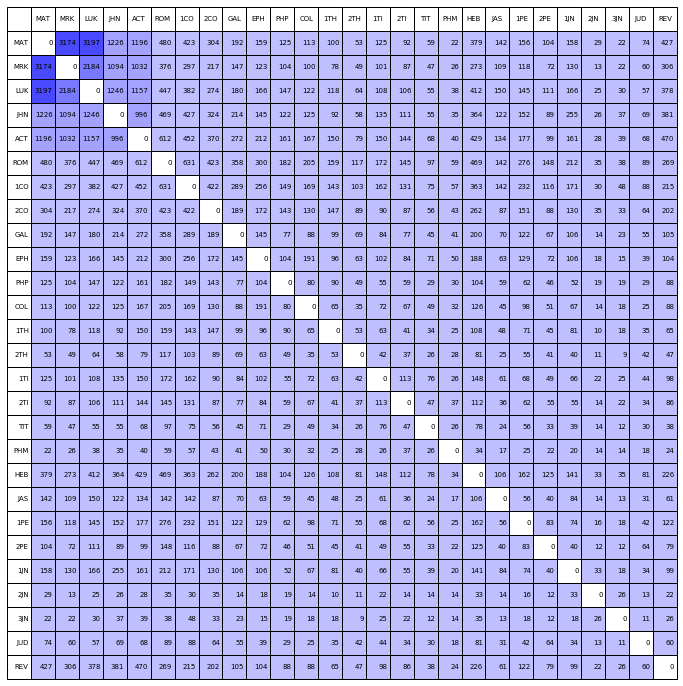

bhadrawahi


Ploting single word counts : bhadrawahi
color_groups : 
 {'0-562.75': '#BFBFFF', '562.75-1125.5': '#A3A3FF', '1125.5-1688.25': '#7879FF', '1688.25-2251.0': '#4949FF'}


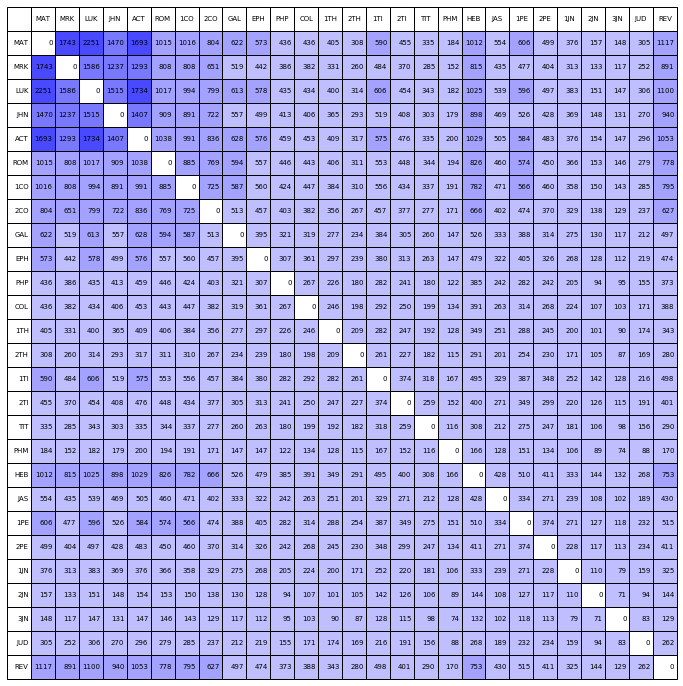



Ploting 3-gram counts : bhadrawahi
color_groups : 
 {'0-743.75': '#BFBFFF', '743.75-1487.5': '#A3A3FF', '1487.5-2231.25': '#7879FF', '2231.25-2975.0': '#4949FF'}


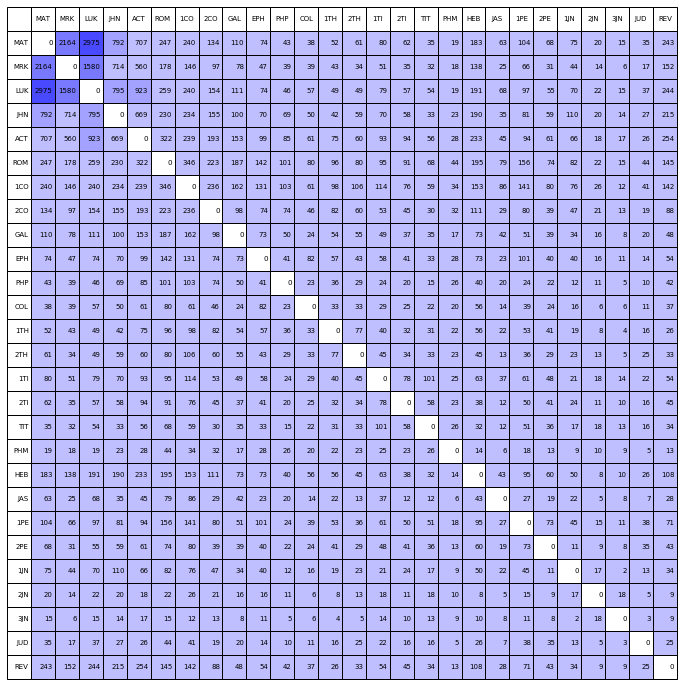

bilaspuri


Ploting single word counts : bilaspuri
color_groups : 
 {'0-539.25': '#BFBFFF', '539.25-1078.5': '#A3A3FF', '1078.5-1617.75': '#7879FF', '1617.75-2157.0': '#4949FF'}


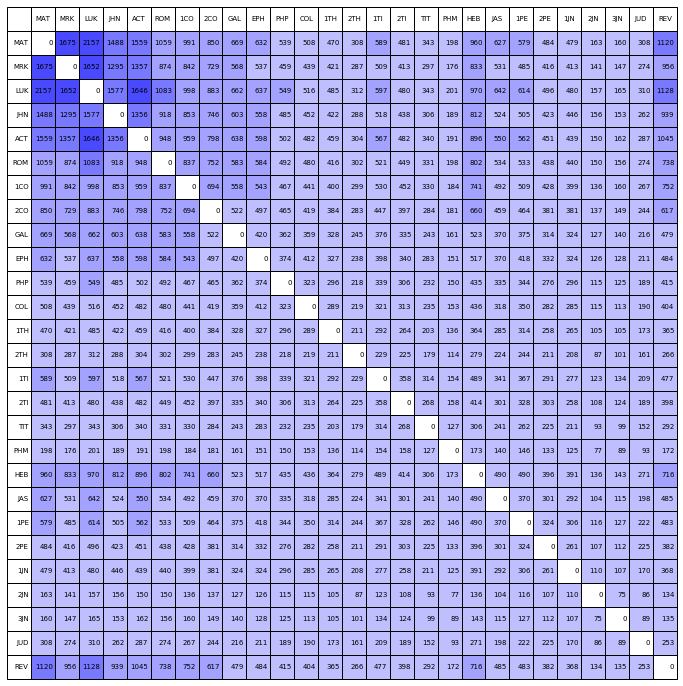



Ploting 3-gram counts : bilaspuri
color_groups : 
 {'0-778.5': '#BFBFFF', '778.5-1557.0': '#A3A3FF', '1557.0-2335.5': '#7879FF', '2335.5-3114.0': '#4949FF'}


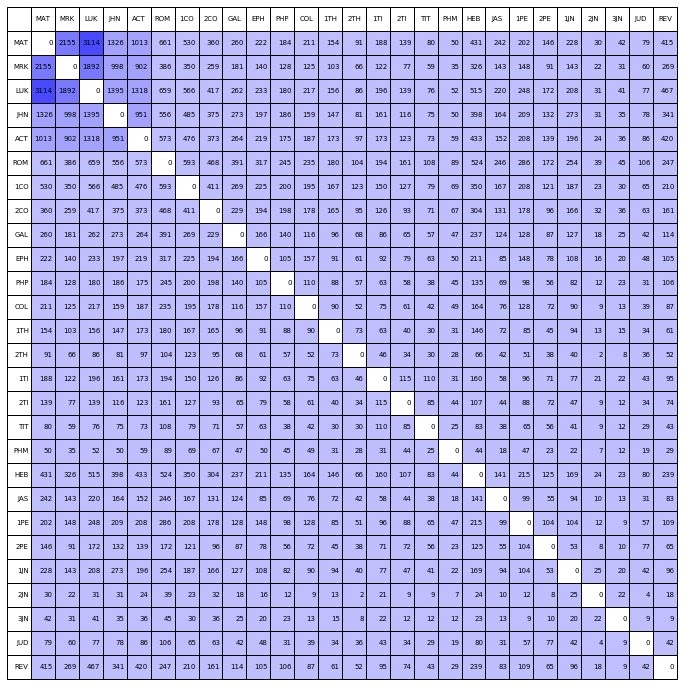

kulvi


Ploting single word counts : kulvi
color_groups : 
 {'0-471.75': '#BFBFFF', '471.75-943.5': '#A3A3FF', '943.5-1415.25': '#7879FF', '1415.25-1887.0': '#4949FF'}


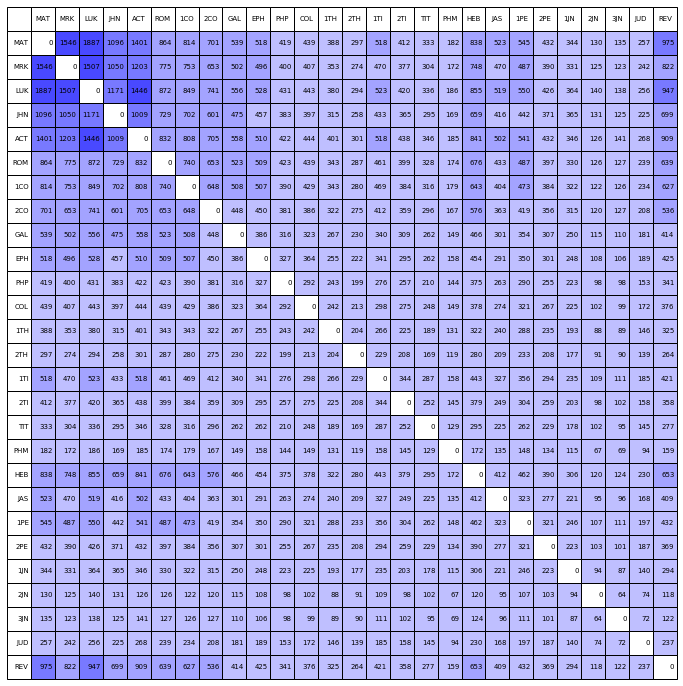



Ploting 3-gram counts : kulvi
color_groups : 
 {'0-955.0': '#BFBFFF', '955.0-1910.0': '#A3A3FF', '1910.0-2865.0': '#7879FF', '2865.0-3820.0': '#4949FF'}


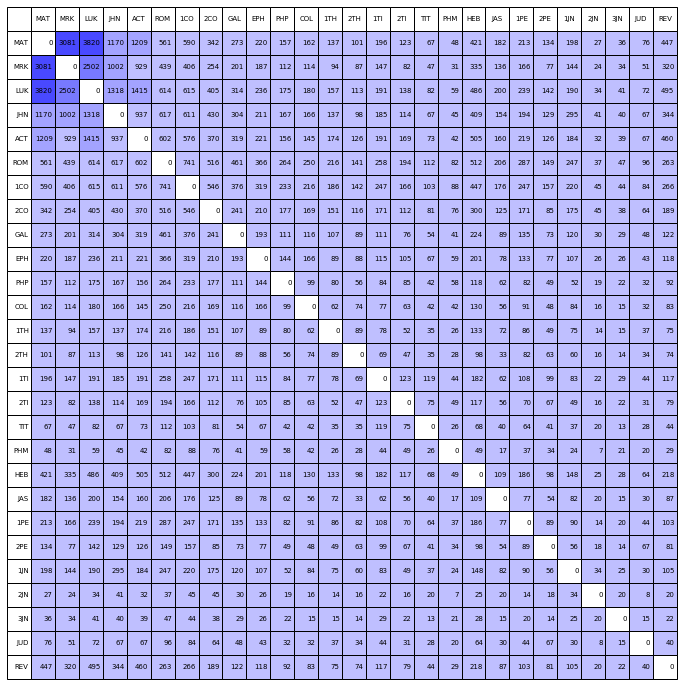

kangri


Ploting single word counts : kangri
color_groups : 
 {'0-470.25': '#BFBFFF', '470.25-940.5': '#A3A3FF', '940.5-1410.75': '#7879FF', '1410.75-1881.0': '#4949FF'}


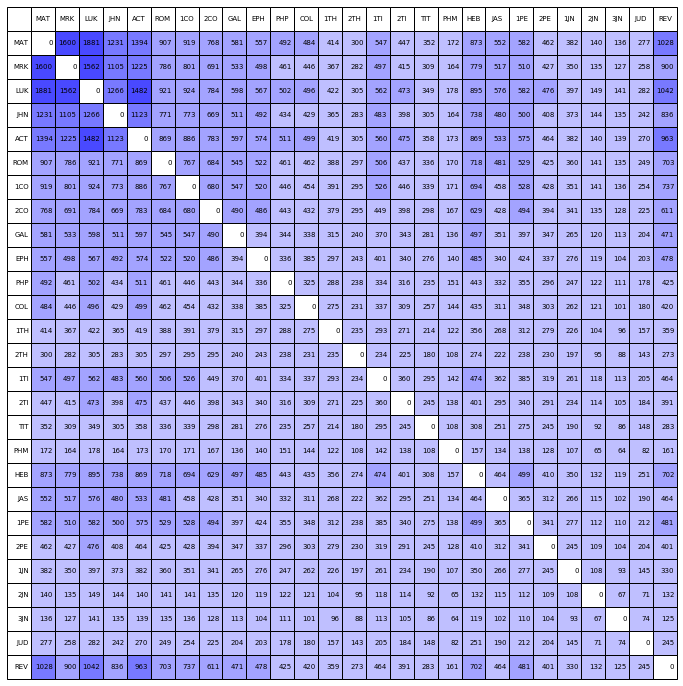



Ploting 3-gram counts : kangri
color_groups : 
 {'0-1175.5': '#BFBFFF', '1175.5-2351.0': '#A3A3FF', '2351.0-3526.5': '#7879FF', '3526.5-4702.0': '#4949FF'}


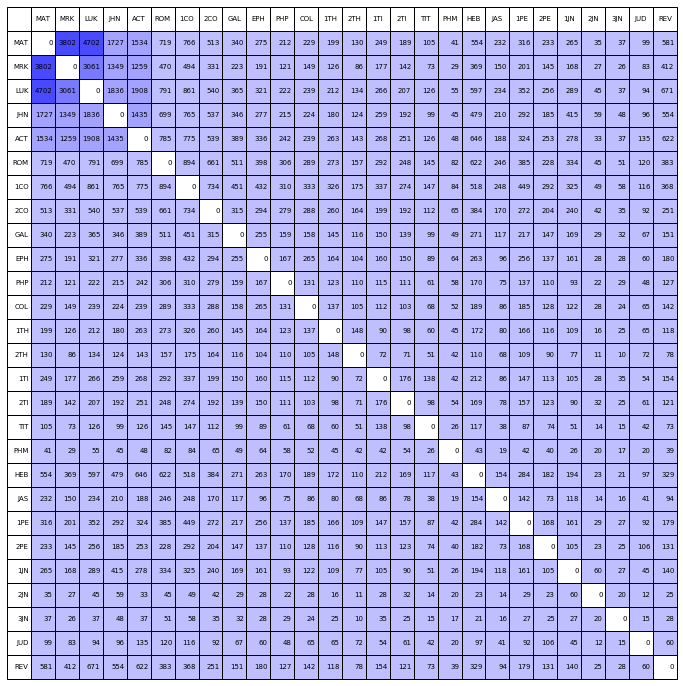

In [175]:
for min_lang in min_languages:
    print(min_lang)
    plot_single_words(min_lang, minority_path)
    plot_3_grams(min_lang, minority_path) 

## gl 



Ploting single word counts : hindi
color_groups : 
 {'0-435.5': '#BFBFFF', '435.5-871.0': '#A3A3FF', '871.0-1306.5': '#7879FF', '1306.5-1742.0': '#4949FF'}


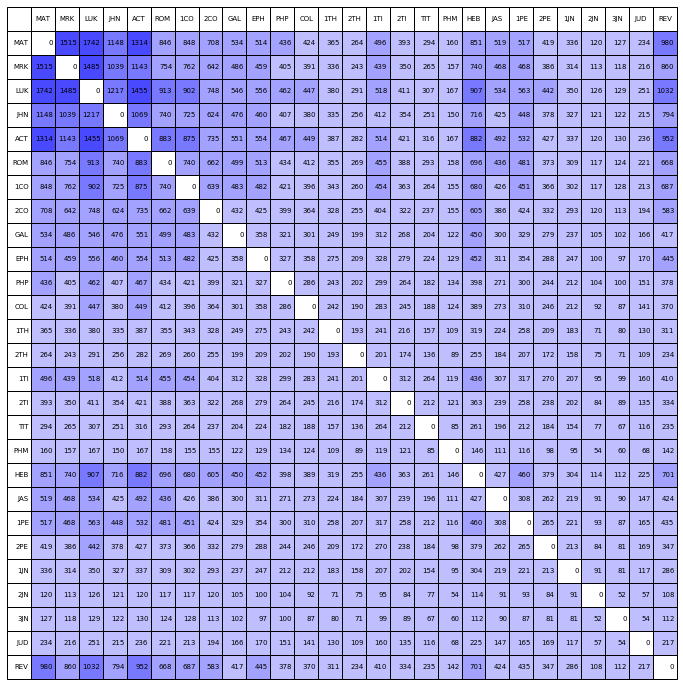



Ploting 3-gram counts : hindi
color_groups : 
 {'0-925.5': '#BFBFFF', '925.5-1851.0': '#A3A3FF', '1851.0-2776.5': '#7879FF', '2776.5-3702.0': '#4949FF'}


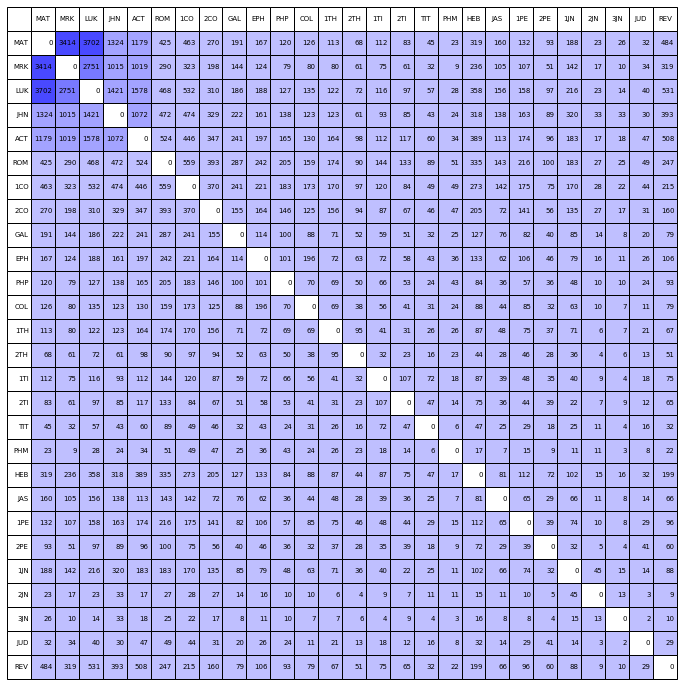

In [176]:
temp_languges = ['hindi', 'malayalam', 'tamil']
for lang in temp_languges:
    plot_single_words(lang, gl_path)
    plot_3_grams(lang, gl_path)
    break